### 3.11.4 多项式函数拟合实验

In [1]:
# 以多项式函数拟合为例
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

#### 3.11.4.1 生成数据集

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [3]:
# 生成的数据集的前两个样本
features[:2], poly_features[:2], labels[:2]

(tensor([[ 0.3313],
         [-0.9905]]),
 tensor([[ 0.3313,  0.1097,  0.0364],
         [-0.9905,  0.9810, -0.9716]]),
 tensor([ 5.2297, -4.9593]))

#### 3.11.4.2 定义、训练和测试模型

In [4]:
# 定义作图函数semilogy
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [5]:
# 多项式函数拟合也使用平方损失函数
# 使用不同复杂度的模型来拟合生成的数据集，把模型定义部分放在fit_and_plot函数中
num_epochs, loss = 100, torch.nn.MSELoss()
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了
    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

#### 3.11.4.3 三阶多项式函数拟合（正常）

final epoch: train loss 0.00011201106099179015 test loss 0.00016773896641097963
weight: tensor([[ 1.2053, -3.3969,  5.5987]]) 
bias: tensor([4.9978])


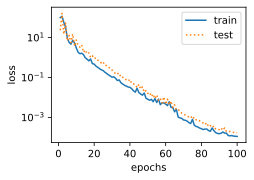

In [6]:
# 模型的训练误差和在测试数据集的误差都较低。训练出的模型参数也接近真实值：
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], 
            labels[:n_train], labels[n_train:])

#### 3.11.4.4 线性函数拟合（欠拟合）

final epoch: train loss 174.55355834960938 test loss 224.16453552246094
weight: tensor([[16.2476]]) 
bias: tensor([2.5898])


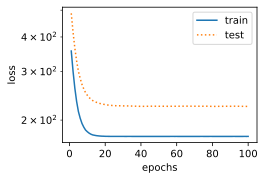

In [7]:
# 模型的训练误差在迭代早期下降后便很难继续降低。
# 在完成最后一次迭代周期后，训练误差依旧很高。
# 线性模型在非线性模型（如三阶多项式函数）生成的数据集上容易欠拟合。
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

#### 3.11.4.5 训练样本不足（过拟合）

final epoch: train loss 2.647118330001831 test loss 148.17347717285156
weight: tensor([[ 3.0720, -1.0422,  2.3639]]) 
bias: tensor([2.0254])


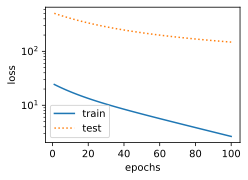

In [8]:
# 使用与数据生成模型同阶的三阶多项式函数模型，如果训练样本不足，该模型依然容易过拟合
# 训练样本过少甚至少于模型参数的数量，使模型显得过于复杂，以至于容易被训练数据中的噪声影响
# 在迭代过程中，尽管训练误差较低，但是测试数据集上的误差却很高。这是典型的过拟合现象
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])